# KIV/DBM2

In [0]:
!pip install lifelines

In [0]:
from textwrap import wrap
from collections import OrderedDict

import calendar
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
from matplotlib.lines import Line2D
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from lifelines.utils import datetimes_to_durations

In [0]:
def image_sequence():
    num = 0
    while True:
        yield num
        num += 1

GEN = image_sequence()

In [0]:
SAVE_FIG = True
FIG_FORM = 'pdf'

In [0]:
diagnosis_list = OrderedDict({
    'I63.0': 'I63.0: Cerebral infarct, large vessel disease with significant carotid stenosis',
    'I63.3': 'I63.3: Cerebral infarct, other large vessel disease',
    'I63.4': 'I63.4: Cerebral infarct, cardic emboli',
    'I63.5': 'I63.5: Cerebral infarct, small vessel / lacunar',
    'I63.8': 'I63.8: Cerebral infarct, other / unusual cause',
    'I63.9': 'I63.9: Cerebral infarct, multiple / unknown cause'
})

# Data Cleaning

In [0]:
def add_months(d, months) -> dt.date:
    """

    :param d: Source date
    :param months:
    :return:
    """
    month = d.month - 1 + months
    year = d.year + month // 12
    month = month % 12 + 1
    day = min(d.day, calendar.monthrange(year, month)[1])
    return dt.date(year, month, day)

In [0]:
def parse_date(date):
    def clean_date(date_string):
        if date_string == 'nan':
            return ''
        if date_string is '0' or date_string is '1':
            return ''
        if '(' in date_string:
            s = re.sub(r'\(.*\)', '', date_string)
            return ''.join(s.split())
        return ''.join(date_string.split())

    def try_parsing_date(text):
        if not text:
            return ''
        for fmt in ('%Y-%m-%d', '%d.%m.%Y', '%m.%Y', '%d.%m.%y', '%Y-%m-%d %H:%M:%S', '%Y-%m-%d%H:%M:%S', '%d/%m/%Y'):
            try:
                actual_date = dt.datetime.strptime(text, fmt)
                if actual_date and fmt != '%m.%Y':
                    return dt.datetime.strptime(text, fmt).date()
                else:
                    return add_months(actual_date, 1)
            except ValueError:
                pass
        raise ValueError(f'No valid date format found: {text}')

    date = clean_date(date)
    date = try_parsing_date(date)
    return date

In [0]:
def to_initial_dates(start_date, end_date):
    if end_date and end_date > add_months(start_date, 12):
        end_date = ''  # censore
    if not end_date:
        return dt.datetime(2000, 1, 1), end_date
    difference = end_date - start_date
    return dt.datetime(2000, 1, 1), dt.datetime(2000, 1, 1) + difference

In [0]:
# read excel sheet
df = pd.read_excel('data/data.xlsx')

# drop rows without valid data
df.dropna(subset=['Zařazen od'], inplace=True)  # rows with null values
df.drop(df[df['ID3'] == 258].index, inplace=True)  # strange one, dead before admission
df.drop(df[df['ID3'] == 563].index, inplace=True)  # strange one, the only string value in column 'TSS příjem'
df.drop(df[df['mRS-out'] == 7].index, inplace=True)  # those are not relevant according to the assignment

# drop columns
df.drop(columns=['ID1', 'ID3'], inplace=True)  # drop ID columns
df.drop(columns=['Obec', 'Okres'], inplace=True)  # drop location columns
df.drop(columns=['datum kontroly', 'pobyt', 'pobyt 1'], inplace=True)  # drop additional information columns
df.drop(columns=['Diag. hypertenze', 'Diag. diabetes', 'Diag. hyperlip.', 'Akt. kuřák', 'Bývalý kuřák',
                 'Ischem. příhoda před > 3M', 'Ischem. příhoda před < 3M', 'Předchozí TIA', 'Fibrilace síní',
                 'Městnavé srdeční selhání', 'Cévní onem.'],
        inplace=True)  # drop columns with risk factors (irrelevant for the task)
df.drop(columns=['událost', 'ADL 1 rok', 'BI 1 rok'], inplace=True)  # no information about meaning of the column
df.drop(columns=['Datum zahájení trombolýzy', 'Datum zahájení trombektomie', 'Lokalizace tr.', 'zpracování 0/1/2 '],
        inplace=True)  # irrelevant for the task
df.drop(columns=['Unnamed: 25'], inplace=True)  # column without values should not be there
df.drop(columns=['Zařazen od', 'Datum 1. hosp.'], inplace=True)  # observation start is taken from another column
df.drop(columns=['mRS-out-3M', 'MRS Před', 'MRS', 'MRS 3M'], inplace=True)  # irrelevant for the task

# modify columns
df['TSS příjem'] = df['TSS příjem'].astype(int)  # make this column's values numerical
df['TSS prop.'] = df['TSS prop.'].fillna(0)  # replace NaN with 0
df['TSS prop.'] = df['TSS prop.'].astype(int)  # make this column's values numerical

# clean column data
df['Etiolog. klas.'] = df['Etiolog. klas.'].apply(lambda x: x[0:5])  # replace diagnosis with it's numerical code
df['datum +'] = df['datum +'].apply(lambda x: parse_date(str(x)))  # transform end_date to correct format
df['Datum vzniku příznaku'] = df['Datum vzniku příznaku'].apply(
    lambda x: dt.datetime.strptime(x, '%d.%m.%Y %H:%M:%S').date())  # transform start
df['mRS-out'] = df['mRS-out'].apply(lambda x: int(x))
df['mRS - 1Y'] = df['mRS - 1Y'].apply(lambda x: int(x))
df['Věk'] = df['Věk'].apply(lambda x: int(x))
df['Pohlaví'] = df['Pohlaví'].apply(lambda x: str.lower(x))

df['start_date_t'], df['end_date_t'] = zip(*df.apply(
    lambda x: to_initial_dates(x['Datum vzniku příznaku'], x['datum +']), axis=1
))

# rename columns
df.rename(columns={'Datum vzniku příznaku': 'start_date',
                   'Etiolog. klas.': 'diagnosis',
                   'TSS příjem': 'tss_in',
                   'TSS prop.': 'tss_out',
                   'datum +': 'end_date',
                   'mRS - 1Y': 'mrs_1y',
                   'mRS-out': 'mrs_out',
                   'Pohlaví': 'sex',
                   'Věk': 'age'},
          inplace=True)

# save to csv
df.to_csv('data/data.csv', index=None)

# Data Plotting

Read cleaned data.

In [0]:
df = pd.read_csv('data/data.csv')

## Histogramy

In [0]:
def plot_hist(df: pd.DataFrame, column, x_label, y_label, title='', x_lim=0, x_ticks: np.ndarray = None):
    # create figure and axes
    fig, ax = plt.subplots()

    # specify type for PyCharm help
    fig: plt.Figure = fig
    ax: plt.Axes = ax

    # plot histogram
    labels, counts = np.unique(df[column], return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)

    # set properties
    if x_ticks is not None:
        ax.set_xticks(x_ticks)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xlim(x_lim - 0.5)

    # show and save plot
    fig.show()
    if SAVE_FIG:
        fig.savefig(f'imgs/image_{next(GEN)}.{FIG_FORM}', format=FIG_FORM)

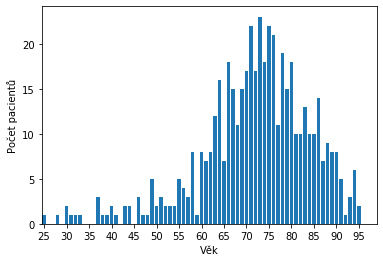

In [0]:
plot_hist(df, 'age', 'Věk', 'Počet pacientů', x_lim=25, x_ticks=np.arange(25, 100, 5))

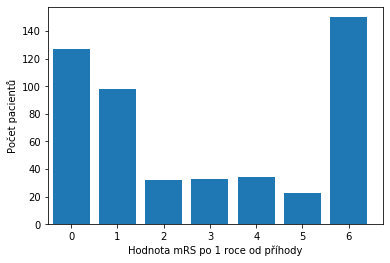

In [0]:
plot_hist(df, 'mrs_1y', 'Hodnota mRS po 1 roce od příhody', 'Počet pacientů')

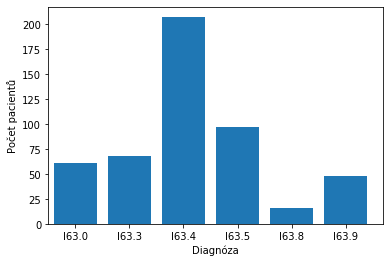

In [0]:
plot_hist(df, 'diagnosis', 'Diagnóza', 'Počet pacientů')

## Logistická regrese

In [0]:
def plot_comparison(df, x, x_label, y_label, title=''):
    fig, ax = plt.subplots()
    data = {'x': x, 'y': df['mrs_1y'] == 6}
    sns.regplot(x='x', y='y', data=data, logistic=True, n_boot=100, ax=ax)

    # create legend
    legend_elements = [Line2D([0], [0], color='b', lw=1, label=f'n = {len(df)}')]

    labels = ['', 'mRS 0-5', '0.2', '0.4', '0.6', '0.8', 'mRS 6']

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.set_yticklabels(labels)

    ax.legend(handles=legend_elements, loc='lower right')

    # show and save plot
    fig.show()
    if SAVE_FIG:
        fig.savefig(f'imgs/image_{next(GEN)}.{FIG_FORM}', format=FIG_FORM)

### Age to mRS comparison

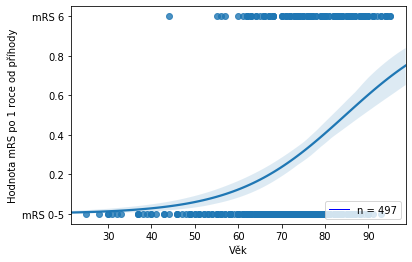

In [0]:
plot_comparison(df, df['age'], 'Věk', 'Hodnota mRS po 1 roce od příhody')

### TSS to mRS comparison

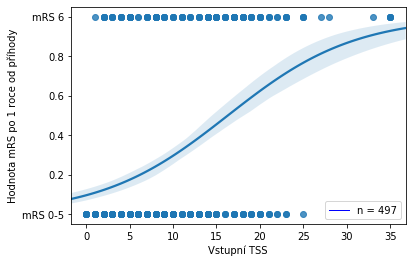

In [0]:
plot_comparison(df, df['tss_in'], 'Vstupní TSS', 'Hodnota mRS po 1 roce od příhody')

### TSS difference to mRS comparison

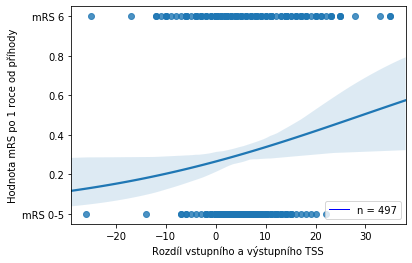

In [0]:
plot_comparison(df, df['tss_in'] - df['tss_out'], 'Rozdíl vstupního a výstupního TSS', 'Hodnota mRS po 1 roce od příhody')

### Mortalita v závislosti na pohlaví

Nejlépe zobrazit kontingenční tabulkou, knihovna statsmodels umožňuje dělat rychlé statistiky a analýzy s kontingenční tabulkou.

https://www.statsmodels.org/stable/contingency_tables.html

In [0]:
a = np.asarray(['Female' if i is 'f' else 'Male' for i in df['sex']])
b = df['mrs_1y'] == 6

tab = pd.crosstab(a, [b], rownames=['Sex'], colnames=['Died'])
table = sm.stats.Table(tab)

print(table.table_orig)

Died    False  True 
Sex                 
Female    153     73
Male      194     77


## Kaplan-Meier

Matematika pro interval spolehlivosti: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf

In [0]:
def plot_lifetimes_for_diagnosis(df, diagnosis, current_time=12, subset_size=80):
    df = df.loc[df['diagnosis'] == diagnosis]

    # create figure and axes
    fig, ax = plt.subplots()

    # specify type for PyCharm help
    fig: plt.Figure = fig
    ax: plt.Axes = ax

    if df.shape[0] >= subset_size:
        df = df.sample(n=subset_size, random_state=1)

    start_times, end_times = df['start_date_t'], df['end_date_t']

    t, e = datetimes_to_durations(start_times, end_times, freq='M', fill_date=dt.datetime(2001, 1, 1))

    plot_lifetimes(t, event_observed=e, ax=ax)

    ax.set_title(f'{diagnosis_list[diagnosis]}\n')
    ax.set_xlabel('Čas od začátku sledování po vznik události v měsících')
    ax.set_ylabel('Sledovaná osoba')
    ax.set_xlim(0, current_time + 1)
    ax.vlines(current_time, 0, subset_size, lw=2, linestyles='--')

    # show and save plot
    fig.show()
    if SAVE_FIG:
        fig.savefig(f'imgs/image_{next(GEN)}.{FIG_FORM}', format=FIG_FORM)

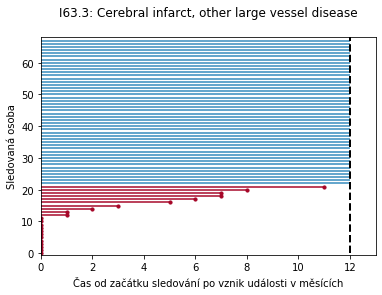

In [0]:
plot_lifetimes_for_diagnosis(df, diagnosis='I63.3')

In [0]:
def start_end_for_diagnosis(df, diagnosis=None):
    """

    Return Tuple (start_times, end_times) where:
        start_times is a vector or list of datetime objects or datetime strings\n
        end_times is a vector or list of (possibly missing) datetime objects or datetime strings

    :param df: Pandas dataframe
    :param diagnosis:
    :return: (start_times, end_times)
    """
    if not diagnosis:
        return df['start_date_t'], df['end_date_t']
    else:
        df = df.loc[df['diagnosis'] == diagnosis]
        return df['start_date_t'], df['end_date_t']

In [0]:
def km_for_diagnosis(df, diagnosis=None):
    fig, ax = plt.subplots()

    # initialize start and end times
    start_times, end_times = start_end_for_diagnosis(df, diagnosis)

    # get data in the right format - t is time_span, e is event (1 is death)
    t, e = datetimes_to_durations(start_times, end_times, freq='D', fill_date=dt.datetime(2001, 1, 1))  # M - months, D - days

    timeline = np.linspace(0, 365, 366)

    # initialize Kaplan-Meier fitter
    kmf = KaplanMeierFitter()

    # fit the data
    kmf.fit(t, event_observed=e, timeline=timeline)

    # plot Kaplan-Meier
    kmf.plot()

    # create legend
    legend_elements = [Line2D([0], [0], color='b', lw=1, label=f'n = {len(start_times)}')]

    # format plot
    ax.set_ylim(0, 1)
    ax.set_xlabel('Čas [dny]')
    ax.set_ylabel('Pravděpodobnost přežití')
    # ax.set_title('\n'.join(wrap(diagnosis_list[diagnosis], 30)))
    if diagnosis:
        ax.set_title(f'{diagnosis_list[diagnosis]}\n')
    else:
        ax.set_title(f'Všechny diagnózy\n')
    ax.legend(handles=legend_elements, loc='lower right')
    ax.margins(y=50)

    # show plot
    fig.show()
    if SAVE_FIG:
        fig.savefig(f'imgs/image_{next(GEN)}.{FIG_FORM}', format=FIG_FORM)

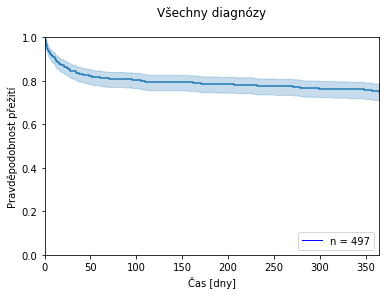

In [0]:
km_for_diagnosis(df)

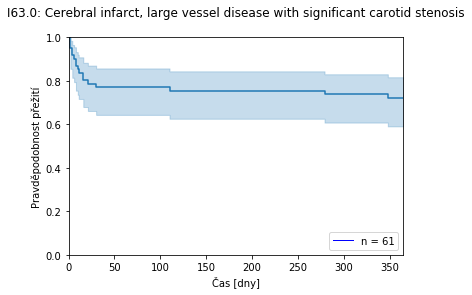

In [0]:
km_for_diagnosis(df, 'I63.0')

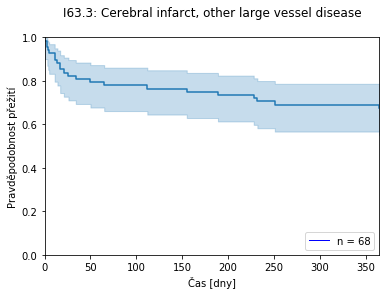

In [0]:
km_for_diagnosis(df, 'I63.3')

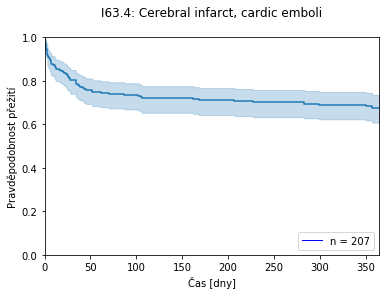

In [0]:
km_for_diagnosis(df, 'I63.4')

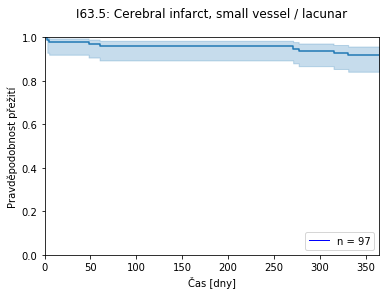

In [0]:
km_for_diagnosis(df, 'I63.5')

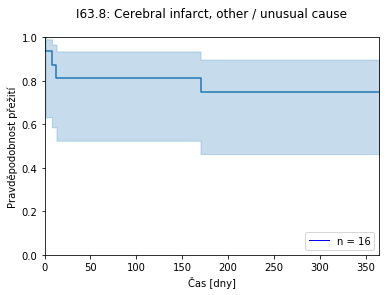

In [0]:
km_for_diagnosis(df, 'I63.8')

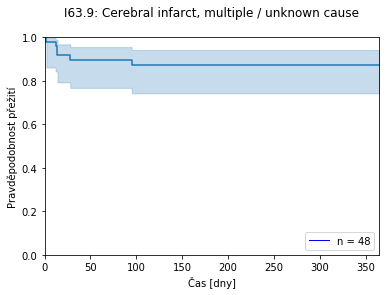

In [0]:
km_for_diagnosis(df, 'I63.9')